In [1]:
import numpy as np
import xarray as xr
import astropy.units as u
from astropy.coordinates import SkyCoord, AltAz, FK5
import n_const.constants as n2const
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [2]:
start_time = np.datetime64("2020-03-20T00:00:00")
delta = 30  # seconds
dt = np.timedelta64(delta, "s")
data_num = int(np.timedelta64(1, "D") / dt)
t = [start_time + i * dt for i in range(data_num)]

dec_list = np.linspace(-90, 68, 100)
dec_list = np.broadcast_to(dec_list, (len(t), len(dec_list))) * u.deg
t = np.atleast_2d(t).T

data_req = {
    "pm0": ("0d0m0s", dec_list, t),
    "p600dec": ("0d0m0s", dec_list + 600 * u.arcsec, t + np.timedelta64(1, "s")),
    "m600dec": ("0d0m0s", abs(dec_list - 600 * u.arcsec + 90 * u.deg) - 90 * u.deg, t + np.timedelta64(1, "s")),
    "p600ra": ("0d10m0s", dec_list, t + np.timedelta64(1, "s")),
    "m600ra": ("359d50m0s", dec_list, t + np.timedelta64(1, "s"))
}

coordinates = {
    obs: SkyCoord(ra=ra, dec=dec, frame=FK5, obstime=obstime, location=n2const.LOC_NANTEN2)
    for obs, (ra, dec, obstime) in data_req.items()
}
altaz_coordinate = {
    obs: equatorial.transform_to(AltAz) for obs, equatorial in coordinates.items()
}
data_array = {
    obs: xr.DataArray(np.array([dat.az.value, dat.alt.value]), dims=["direction", "t", "dec"])
    for obs, dat in altaz_coordinate.items()
}
coords = {
    "direction": ["az", "el"],
    "dec": np.unique(dec_list, axis=0)[0],
    "t": t.T[0]
}
data_array.update(coords)
data = xr.Dataset(data_array)

In [3]:
az_speed = xr.Dataset({
    obs: (dat.sel(direction="az") - data.pm0.sel(direction="az")) * 3600 for obs, dat in data.items()
})

[Text(0.65, 0.8, '30'),
 Text(0.65, 0.7050000000000001, '45'),
 Text(0.65, 0.6100000000000001, '60'),
 Text(0.65, 0.515, '75')]

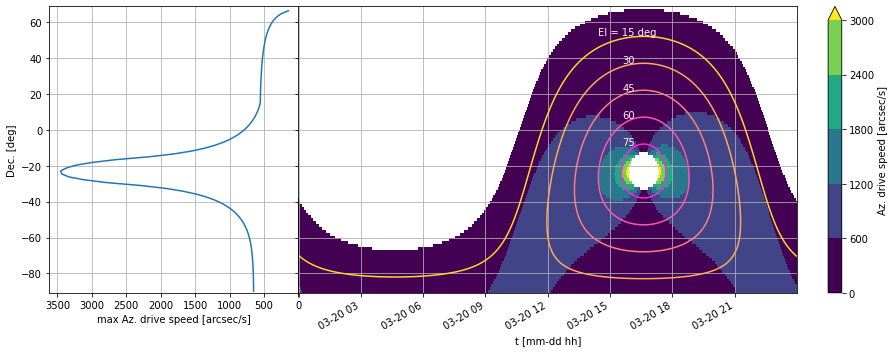

In [4]:
fig = plt.figure(figsize=(13, 5))
gs = GridSpec(nrows=1, ncols=2, width_ratios=[1, 2.5], wspace=0)
axes = [fig.add_subplot(spec) for spec in gs]

mode = "m600dec"

# plot left graph
abs(az_speed[mode]).where(
    (data[mode].sel(direction="el") < 80) & (data[mode].sel(direction="el") > 0) & (abs(az_speed[mode]) < 10000)
).max("t").plot(y="dec", ax=axes[0], xincrease=False)
axes[0].set(ylabel="Dec. [deg]", xlabel="max Az. drive speed [arcsec/s]", xlim=(None, 0), title="")
axes[0].grid()

# plot right map
abs(az_speed[mode]).where(
    (data[mode].sel(direction="el") < 80) & (data[mode].sel(direction="el") > 0) & (abs(az_speed[mode]) < 10000)
).plot(
    x="t", ax=axes[1], zorder=-1,
    levels=[600 * i for i in range(6)],
    cbar_kwargs={"label": "Az. drive speed [arcsec/s]"}
)
# plot right contour
data[mode].where(
    (data[mode].sel(direction="el") < 80) & (data[mode].sel(direction="el") > 0) & (abs(az_speed[mode]) < 10000)
).sel(direction="el").plot.contour(cmap="spring_r", ax=axes[1], x="t")

axes[1].set(rasterization_zorder=0, xlabel="t [mm-dd hh]", ylabel="", title="")
axes[1].tick_params(labelleft=False)
axes[1].grid()

# align the 2 axes
axes[0].sharey(axes[1])
plt.tight_layout()

# remove overlapping tick-label
axes[1].set_xticks(axes[1].get_xticks())
labels=axes[1].get_xticklabels()
labels[0] = ""
axes[1].set_xticklabels(labels)

# annotate contour levels
axes[1].text(0.6, 0.9, "El = 15 deg", c=(1,0.95,0.95), transform=axes[1].transAxes)
[
    axes[1].text(
        0.65, 0.8 - 0.095 * i,
        15 * (i + 2),
        c=(1,0.95,0.95),
        transform=axes[1].transAxes
    ) for i in range(4)
]

# plt.savefig(f"./az_drive_speed_{mode}.pdf", dpi=400)

[Text(0.65, 0.8, '30'),
 Text(0.65, 0.7050000000000001, '45'),
 Text(0.65, 0.6100000000000001, '60'),
 Text(0.65, 0.515, '75')]

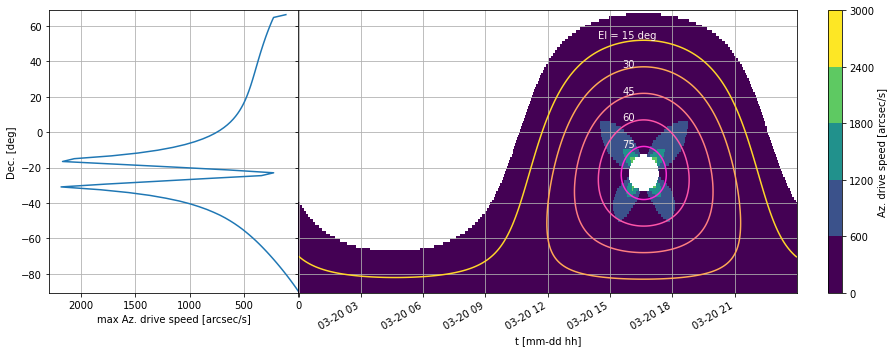

In [5]:
fig = plt.figure(figsize=(13, 5))
gs = GridSpec(nrows=1, ncols=2, width_ratios=[1, 2.5], wspace=0)
axes = [fig.add_subplot(spec) for spec in gs]

modes = data_req.keys()
data_ = [abs(az_speed[mode]) for mode in modes if mode.find("600")!=-1]
az_speed_ = xr.DataArray(
    np.array(data_),
    dims=["obs", "t", "dec"],
    coords={
        "obs": [dat.name for dat in data_],
        "dec": np.unique(dec_list, axis=0)[0],
        "t": t.T[0]
    }
)
el = data.pm0.sel(direction="el")


# plot left graph
az_speed_.where(
    (el < 80) & (el > 0) & (az_speed_ < 10000)
).min(axis=0).max("t").plot(y="dec", ax=axes[0], xincrease=False)
axes[0].set(ylabel="Dec. [deg]", xlabel="max Az. drive speed [arcsec/s]", xlim=(None, 0), title="")
axes[0].grid()

# plot right map
az_speed_.where(
    (el < 80) & (el > 0) & (az_speed_ < 10000)
).min(axis=0).plot(
    x="t", ax=axes[1], zorder=-1,
    levels=[600 * i for i in range(6)],
    cbar_kwargs={"label": "Az. drive speed [arcsec/s]"}
)
# plot right contour
data.pm0.where(
    (el < 80) & (el > 0) & (az_speed_ < 10000).any()
).sel(direction="el").plot.contour(cmap="spring_r", ax=axes[1], x="t")

axes[1].set(rasterization_zorder=0, xlabel="t [mm-dd hh]", ylabel="", title="")
axes[1].tick_params(labelleft=False)
axes[1].grid()

# align the 2 axes
axes[0].sharey(axes[1])
plt.tight_layout()

# remove overlapping tick-label
axes[1].set_xticks(axes[1].get_xticks())
labels=axes[1].get_xticklabels()
labels[0] = ""
axes[1].set_xticklabels(labels)

# annotate contour levels
axes[1].text(0.6, 0.9, "El = 15 deg", c=(1,0.95,0.95), transform=axes[1].transAxes)
[
    axes[1].text(
        0.65, 0.8 - 0.095 * i,
        15 * (i + 2),
        c=(1,0.95,0.95),
        transform=axes[1].transAxes
    ) for i in range(4)
]

# plt.savefig("./az_drive_speed_minimum.pdf", dpi=400)